In [19]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from matplotlib import pyplot as plt
from sklearn.base import ClassifierMixin
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import (
    train_test_split,
)
from sklearn.svm import SVC

np.random.seed(42)
pd.set_option("display.max_rows", 80)
pd.set_option("display.width", 1920)
pd.set_option("display.float_format", "{:20,.2f}".format)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
plt.rcParams["figure.dpi"] = 150


In [20]:
df = pd.read_csv("./normalized_nybnb.csv").astype(np.float32)
X, y = df.drop(columns=["High Review Score"]), df["High Review Score"]

rus = RandomUnderSampler(random_state=42)
X, y = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=42,
    stratify=y,
)

target_names = ["Low", "High"]
n_features = X_train.shape[1]


In [21]:
classifiers = {
    "SVM with Linear kernel": SVC(kernel="linear"),
    "SVM with RBF kernel": SVC(kernel="rbf"),
    "SVM with Polynomial kernel": SVC(kernel="poly"),
    "SVM with Sigmoid kernel": SVC(kernel="sigmoid"),
}
for cls in classifiers.keys():
    classifiers[cls].fit(X_train, y_train)
    print(cls, classifiers[cls])


SVM with Linear kernel SVC(kernel='linear')
SVM with RBF kernel SVC()
SVM with Polynomial kernel SVC(kernel='poly')
SVM with Sigmoid kernel SVC(kernel='sigmoid')


Test metrics
SVM with Linear kernel
Accuracy :  0.6153846153846154
Balanced Accuracy :  0.6153846153846154
              precision    recall  f1-score   support

         Low       0.65      0.50      0.57       663
        High       0.59      0.73      0.65       663

    accuracy                           0.62      1326
   macro avg       0.62      0.62      0.61      1326
weighted avg       0.62      0.62      0.61      1326

[[333 330]
 [180 483]]
SVM with RBF kernel
Accuracy :  0.6342383107088989
Balanced Accuracy :  0.6342383107088989
              precision    recall  f1-score   support

         Low       0.67      0.53      0.59       663
        High       0.61      0.74      0.67       663

    accuracy                           0.63      1326
   macro avg       0.64      0.63      0.63      1326
weighted avg       0.64      0.63      0.63      1326

[[353 310]
 [175 488]]
SVM with Polynomial kernel
Accuracy :  0.6138763197586727
Balanced Accuracy :  0.6138763197586727
    

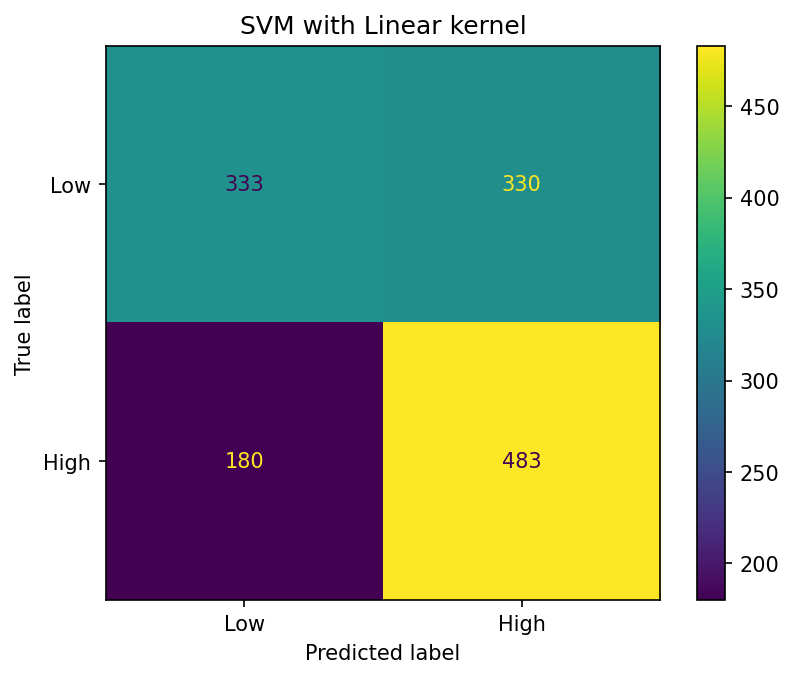

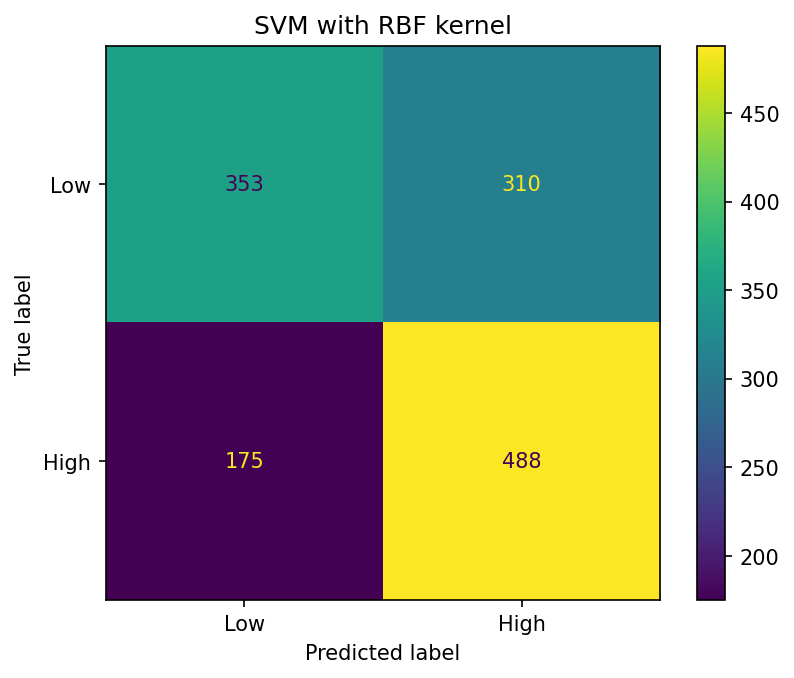

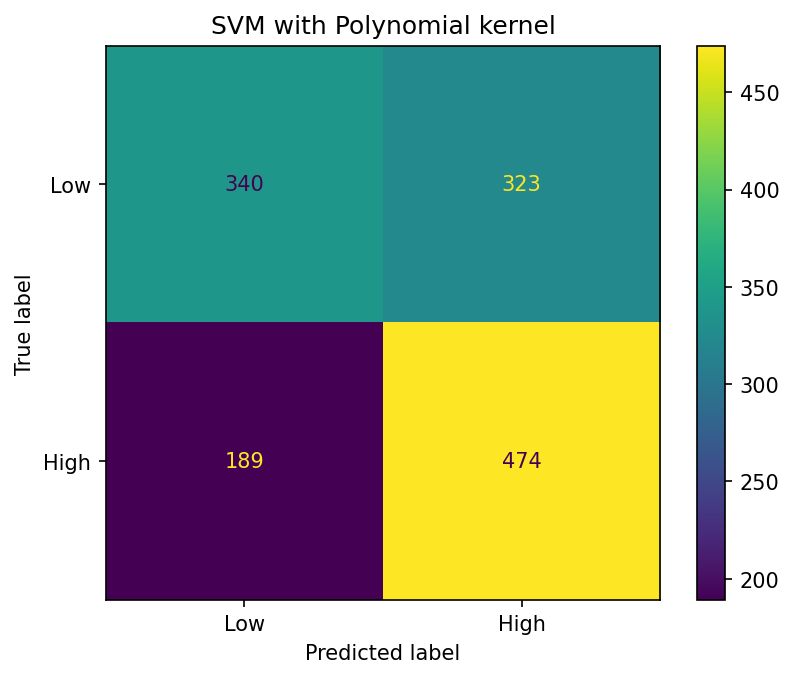

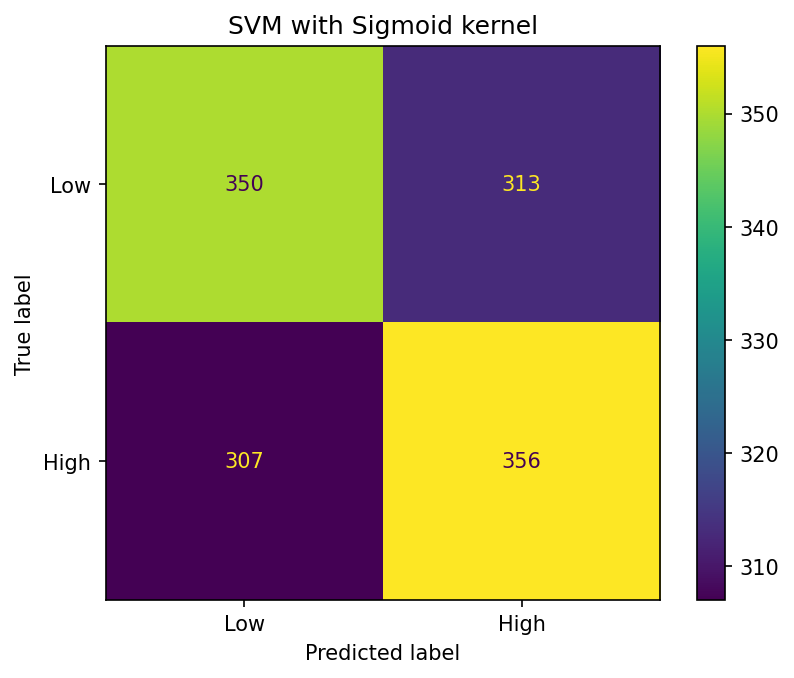

In [22]:
print('Test metrics')
for name, cls in classifiers.items():
    print(name)
    pred = cls.predict(X_test)
    print("Accuracy : ", accuracy_score(y_test, pred))
    print("Balanced Accuracy : ", balanced_accuracy_score(y_test, pred))
    print(classification_report(y_test, pred, target_names=target_names))
    print(cm := confusion_matrix(y_test, pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
    disp.plot()
    disp.ax_.set_title(name)


In [17]:
from typing import List, Union

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.base import ClassifierMixin
from tqdm.notebook import trange

Number = Union[int, float, complex, np.number]


def pairplot_with_decision_regions(
    title: str,
    cls: ClassifierMixin,
    data: pd.DataFrame,
    X: pd.DataFrame,
    y: pd.DataFrame,
    X_test: pd.DataFrame,
    feature_indices: List[int],
    feature_names: List[str],
    filler_values: List[Number],
    filler_ranges: List[Number],
) -> None:
    n = len(feature_indices)
    fig, axarr = plt.subplots(n, n, figsize=(10, 10))
    filler_values_dict = dict(enumerate(filler_values))
    filler_ranges_dict = dict(enumerate(filler_ranges))
    color_pallete = ["#2596be", "#ff7f0e", "#2ca02c"]  # sns.color_palette("tab10")
    contourf_kwargs = {"alpha": 0.2}
    scatter_kwargs = {
        "s": 12,
        "edgecolor": None,
        "alpha": 0.7,
        "marker": "o",
        "c": color_pallete,
    }
    scatter_highlight_kwargs = {
        "s": 12,
        "label": "Test data",
        "alpha": 0.7,
        "c": None,
    }
    for i in trange(n):
        for j in trange(n):
            ax = axarr[i, j]
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            index_x, index_y = feature_indices[i], feature_indices[j]
            if i == j:
                sns.kdeplot(
                    ax=ax,
                    data=data,
                    x=feature_names[i],
                    hue="High Review Score",
                    palette="tab10",
                    alpha=0.5,
                    linewidth=0,
                    multiple="stack",
                    legend=False,
                )
                ax.set(
                    xlabel=None,
                    ylabel=None,
                )
            else:
                plot_decision_regions(
                    X.values,
                    y.values,
                    clf=cls,
                    ax=ax,
                    feature_index=[index_x, index_y],
                    filler_feature_values={
                        key: filler_values_dict[key]
                        for key in filler_values_dict
                        if key != index_x and key != index_y
                    },
                    filler_feature_ranges={
                        key: filler_ranges_dict[key]
                        for key in filler_ranges_dict
                        if key != index_x and key != index_y
                    },
                    legend=0,
                    X_highlight=X_test.values,
                    scatter_kwargs=scatter_kwargs,
                    contourf_kwargs=contourf_kwargs,
                    scatter_highlight_kwargs=scatter_highlight_kwargs,
                )
            ax.tick_params(
                axis="both",
                which="both",
                bottom=False,
                left=False,
                labelbottom=False,
                labelleft=False,
            )
            if i == n - 1:
                ax.set(xlabel=" ".join(feature_names[j].split("_")[:2]))
                ax.tick_params(
                    axis="x",
                    which="both",
                    bottom=True,
                    labelbottom=True,
                )
            if j == 0:
                ax.set(ylabel=" ".join(feature_names[i].split("_")[:2]))
                ax.tick_params(
                    axis="y",
                    which="both",
                    left=True,
                    labelleft=True,
                )
    handles, labels = axarr[0, 1].get_legend_handles_labels()

    add_legend(fig, handles, ["0", "1", "Test data"])

    fig.suptitle(f"Decision Boundary for\n{title}", size="xx-large")
    plt.show()


def add_legend(fig, handles, labels):
    # https://github.com/mwaskom/seaborn/blob/bfbd6ad5b9717db42e302177d867b4a273df162b/seaborn/axisgrid.py#L89
    figlegend = fig.legend(handles, labels, loc="center right")

    # See https://github.com/matplotlib/matplotlib/issues/19197 for context
    fig.canvas.draw()
    if fig.stale:
        try:
            fig.draw(fig.canvas.get_renderer())
        except AttributeError:
            pass

    legend_width = figlegend.get_window_extent().width / fig.dpi
    fig_width, fig_height = fig.get_size_inches()
    fig.set_size_inches(fig_width + legend_width, fig_height)

    # Draw the plot again to get the new transformations
    fig.canvas.draw()
    if fig.stale:
        try:
            fig.draw(fig.canvas.get_renderer())
        except AttributeError:
            pass

    # Now calculate how much space we need on the right side
    legend_width = figlegend.get_window_extent().width / fig.dpi
    space_needed = legend_width / (fig_width + legend_width)
    margin = 0.01
    space_needed = margin + space_needed
    right = 1 - space_needed

    # Place the subplot axes to give space for the legend
    fig.subplots_adjust(right=right)


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\mlxtend\plotting\decision_regions.py:269: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\mlxtend\plotting\decision_regions.py:269: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwar

  0%|          | 0/5 [00:00<?, ?it/s]

i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\mlxtend\plotting\decision_regions.py:269: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\mlxtend\plotting\decision_regions.py:269: UserWarning: No contour levels were found within the data range.
  ax.contour(xx, yy, Z, cset.levels, **contour_kwargs)
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
i:\SIT\2022F\CS513\final\.venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


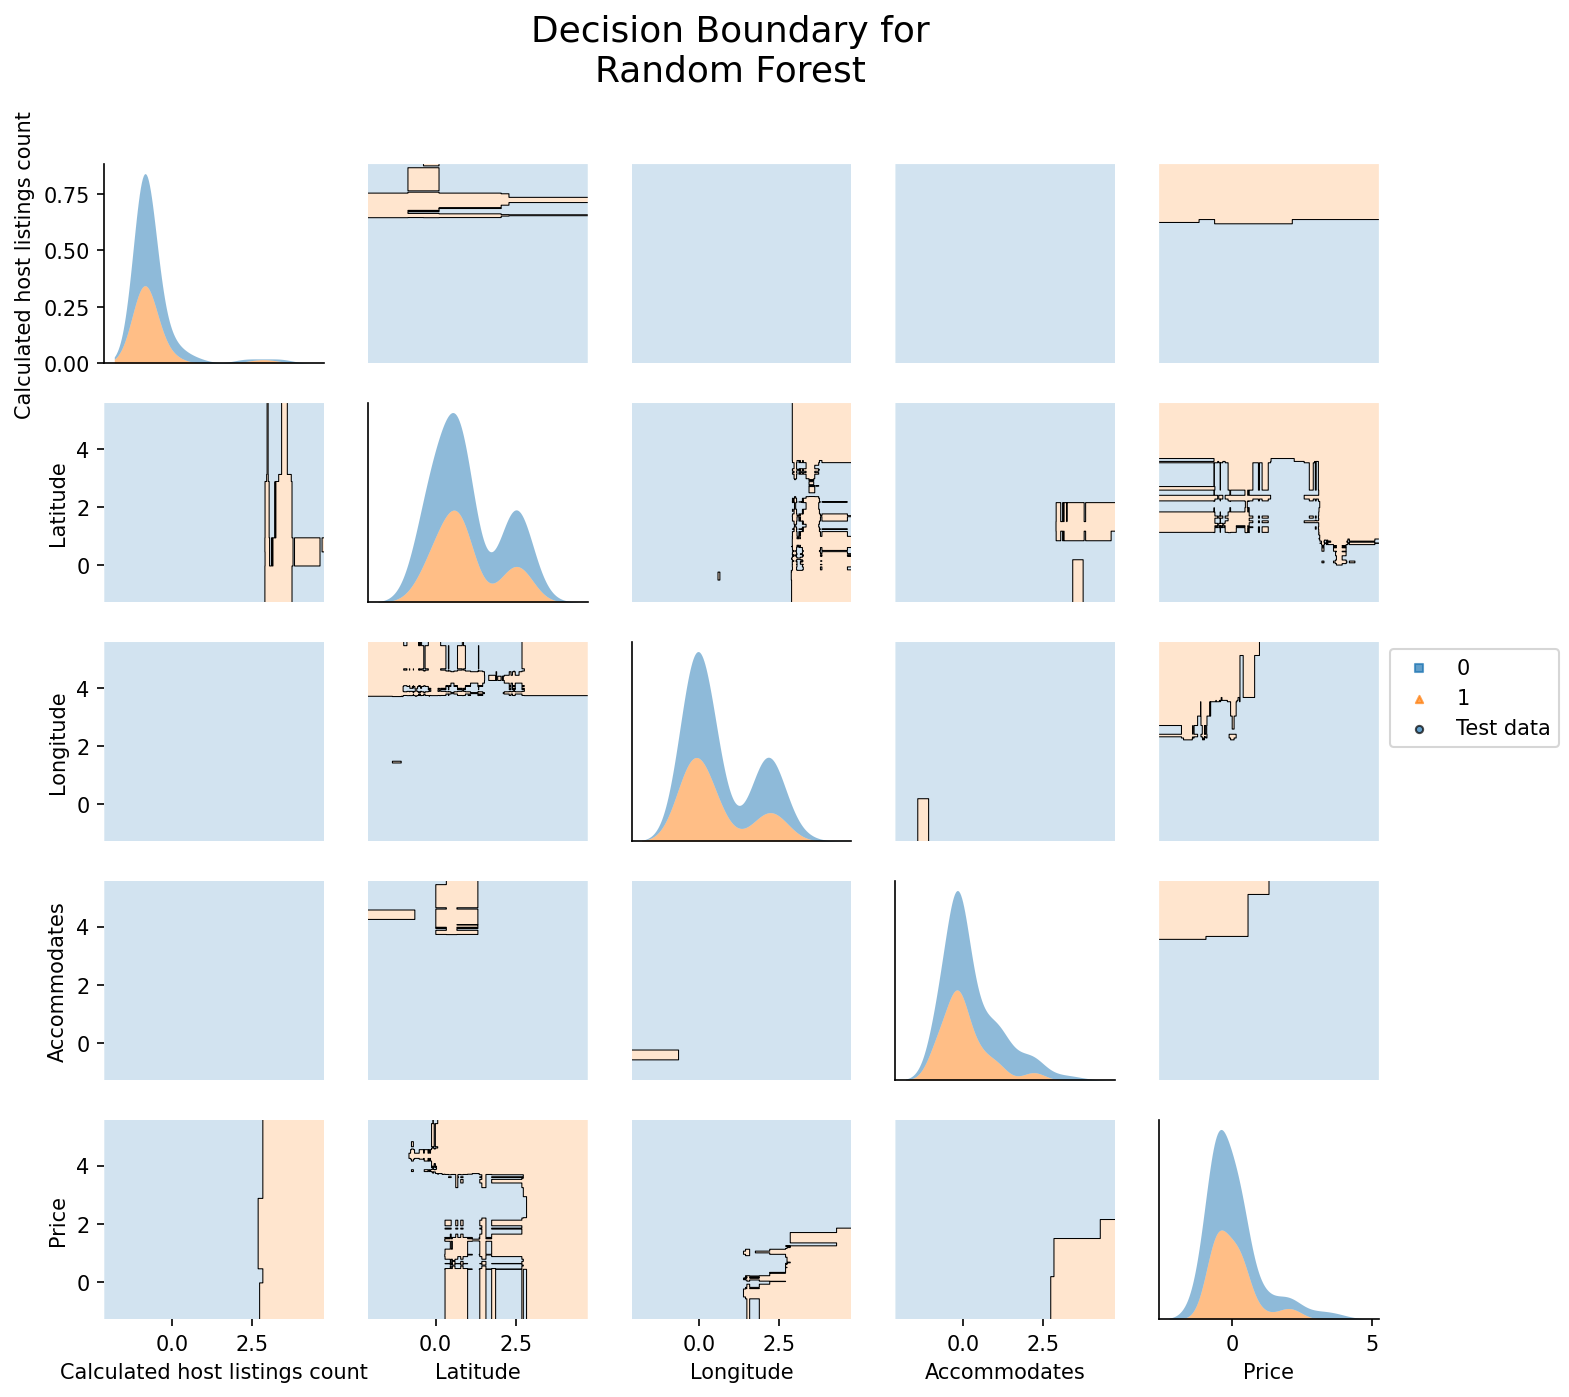

In [18]:
# from tqdm import tqdm
# for name, cls in tqdm(classifiers.items()):
#     pairplot_with_decision_regions(
#         name,
#         cls,
#         df.head(100),
#         X[:100],
#         y[:100].astype(int),
#         X_test[:10],
#         feature_indices=[
#             2,
#             3,
#             4,
#             5,
#             9,
#         ],
#         feature_names=[
#             "Calculated host listings count",
#             "Latitude",
#             "Longitude",
#             "Accommodates",
#             "Price",
#         ],
#         filler_values=[0] * (len(df.columns.tolist()) - 1),
#         filler_ranges=[1] * (len(df.columns.tolist()) - 1),
#     )
pairplot_with_decision_regions(
    'Random Forest',
    classifiers["Random Forest"],
    df.head(100),
    X[:100],
    y[:100].astype(int),
    X_test[:10],
    feature_indices=[
        2,
        3,
        4,
        5,
        9,
    ],
    feature_names=[
        "Calculated host listings count",
        "Latitude",
        "Longitude",
        "Accommodates",
        "Price",
    ],
    filler_values=[0] * (len(df.columns.tolist()) - 1),
    filler_ranges=[1] * (len(df.columns.tolist()) - 1),
)